# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("returns.csv")[1:]
rets.head()

,Date,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
1,2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2,2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
3,2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
4,2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
5,2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [21]:
# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']
rets.head()

,USA_EWJ,USA_EWT,USA_MCHI,USA_EWY,USA_EWZ,USA_INDA,USA_ACWV,USA_IDV,USA_EWC,USA_EWU,...,CAN_HULC.TO,CAN_HMUS.TO,CAN_HSUV.TO,USA_CNY=X,USA_BRL=X,USA_ZAR=X,USA_RUB=X,USA_EUR=X,USA_JPY=X,USA_MXN=X
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,0.000804,-0.007407,NaN,0.002263,0.004396,NaN,NaN,-0.009259,-0.010412,0.010462,...,NaN,NaN,NaN,-0.001760,0.019189,0.006326,0.0,0.000134,0.006743,-0.000384
2011-01-05,-0.007231,-0.016584,NaN,0.000376,-0.011616,NaN,NaN,-0.002596,0.002023,-0.002157,...,NaN,NaN,NaN,0.002584,0.012754,0.003853,0.0,0.002671,0.004506,-0.004249
2011-01-06,0.000000,-0.002108,NaN,-0.006960,-0.010049,NaN,NaN,-0.009891,-0.004847,-0.008647,...,NaN,NaN,NaN,-0.002956,0.004498,0.008670,0.0,0.012522,0.014030,0.003119
2011-01-07,0.003777,-0.015632,NaN,0.005493,-0.009119,NaN,NaN,-0.005258,0.000406,-0.003925,...,NaN,NaN,NaN,0.005929,0.006507,0.012983,0.0,0.013551,0.001334,0.000573
2011-01-10,0.000000,0.002146,NaN,-0.014883,-0.010071,NaN,NaN,0.000529,-0.003651,0.001751,...,NaN,NaN,NaN,0.000151,-0.029895,-0.000295,0.0,0.006620,-0.003241,-0.001063


In [81]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0


In [82]:
sum(rets["USA_RUB=X"] > 100)

0

In [83]:
rets.index

DatetimeIndex(['2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07',
               '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13',
               '2011-01-14', '2011-01-17',
               ...
               '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-28', '2021-06-29', '2021-06-30', '2021-07-01',
               '2021-07-02', '2021-07-05'],
              dtype='datetime64[ns]', name='Date', length=2740, freq=None)

In [84]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

In [85]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [86]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])

2011-01-31 00:00:00 2011-07-29 00:00:00


In [87]:
# Sanity check
print(semiannual[1].index[0],semiannual[1].index[-1])

2011-08-01 00:00:00 2012-01-31 00:00:00


In [88]:
# Sanity check
print(semiannual[19].index[0],semiannual[19].index[-1])

2020-07-31 00:00:00 2021-01-29 00:00:00


In [89]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)
corrs

USA_EWJ      0.435156
USA_EWT      0.511699
USA_MCHI     0.528725
USA_EWY      0.541586
USA_EWZ      0.432182
               ...   
USA_ZAR=X    0.118197
USA_RUB=X    0.084428
USA_EUR=X    0.151444
USA_JPY=X    0.082320
USA_MXN=X    0.462142
Length: 128, dtype: float64

In [90]:
# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XFR.TO    0.075507
CAN_CMR.TO    0.081464
USA_JPY=X     0.082320
USA_RUB=X     0.084428
USA_BRL=X     0.085703
CAN_HXQ.TO    0.097759
CAN_HHF.TO    0.113232
CAN_CBO.TO    0.113303
USA_ZAR=X     0.118197
USA_CNY=X     0.120320
CAN_HUZ.TO    0.144101
USA_EUR=X     0.151444
CAN_XSC.TO    0.154957
CAN_SVR.TO    0.162192
CAN_HXF.TO    0.165272
CAN_XGD.TO    0.181217
CAN_HUN.TO    0.185430
CAN_XIG.TO    0.186638
CAN_CVD.TO    0.190808
USA_KSA       0.198407
CAN_CBH.TO    0.199100
CAN_HUG.TO    0.208522
CAN_HTB.TO    0.237717
CAN_XUU.TO    0.248717
CAN_CGL.TO    0.253634
CAN_CLF.TO    0.280254
CAN_CGR.TO    0.283629
CAN_CLG.TO    0.284980
CAN_HXE.TO    0.285884
USA_QAT       0.286492
dtype: float64

In [113]:
# First 15 CAN values
[x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

['CAN_HSAV.TO',
 'CAN_CMR.TO',
 'CAN_HHF.TO',
 'CAN_XGD.TO',
 'CAN_HUG.TO',
 'CAN_CLG.TO',
 'CAN_CGL.TO',
 'CAN_HUN.TO',
 'CAN_CBH.TO',
 'CAN_CLF.TO',
 'CAN_CSD.TO',
 'CAN_XFR.TO',
 'CAN_XIG.TO',
 'CAN_HBB.TO',
 'CAN_SVR.TO']

In [115]:
top15[1]

['USA_JPY=X',
 'USA_ZAR=X',
 'USA_RUB=X',
 'USA_BRL=X',
 'USA_EUR=X',
 'USA_CNY=X',
 'USA_EPU',
 'USA_TUR',
 'USA_EPHE',
 'USA_ECH',
 'USA_EWJ',
 'USA_THD',
 'USA_EIRL',
 'USA_EIDO',
 'USA_MCHI',
 'CAN_CMR.TO',
 'CAN_HUN.TO',
 'CAN_CVD.TO',
 'CAN_CGL.TO',
 'CAN_HUG.TO',
 'CAN_XIG.TO',
 'CAN_CGR.TO',
 'CAN_DLR.TO',
 'CAN_XGD.TO',
 'CAN_HUC.TO',
 'CAN_CBO.TO',
 'CAN_CHB.TO',
 'CAN_HUZ.TO',
 'CAN_SVR.TO',
 'CAN_CWW.TO']

In [119]:
# Loop through each semiannual period, save the 15 Canadian and USA assets with the
# lowest average correlation
top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [120]:
# Sanity check
top15[1]

['USA_JPY=X',
 'USA_ZAR=X',
 'USA_RUB=X',
 'USA_BRL=X',
 'USA_EUR=X',
 'USA_CNY=X',
 'USA_EPU',
 'USA_TUR',
 'USA_EPHE',
 'USA_ECH',
 'USA_EWJ',
 'USA_THD',
 'USA_EIRL',
 'USA_EIDO',
 'USA_MCHI',
 'CAN_CMR.TO',
 'CAN_HUN.TO',
 'CAN_CVD.TO',
 'CAN_CGL.TO',
 'CAN_HUG.TO',
 'CAN_XIG.TO',
 'CAN_CGR.TO',
 'CAN_DLR.TO',
 'CAN_XGD.TO',
 'CAN_HUC.TO',
 'CAN_CBO.TO',
 'CAN_CHB.TO',
 'CAN_HUZ.TO',
 'CAN_SVR.TO',
 'CAN_CWW.TO']

In [121]:
# We only need the index
top15[1]

['USA_JPY=X',
 'USA_ZAR=X',
 'USA_RUB=X',
 'USA_BRL=X',
 'USA_EUR=X',
 'USA_CNY=X',
 'USA_EPU',
 'USA_TUR',
 'USA_EPHE',
 'USA_ECH',
 'USA_EWJ',
 'USA_THD',
 'USA_EIRL',
 'USA_EIDO',
 'USA_MCHI',
 'CAN_CMR.TO',
 'CAN_HUN.TO',
 'CAN_CVD.TO',
 'CAN_CGL.TO',
 'CAN_HUG.TO',
 'CAN_XIG.TO',
 'CAN_CGR.TO',
 'CAN_DLR.TO',
 'CAN_XGD.TO',
 'CAN_HUC.TO',
 'CAN_CBO.TO',
 'CAN_CHB.TO',
 'CAN_HUZ.TO',
 'CAN_SVR.TO',
 'CAN_CWW.TO']

In [122]:
# Let's create a one-period example before looping through them all, start
# with 100k capital
capital = 100000

In [123]:
# Use previous period's lowest corrs to construct portfolio
# for current period
returns = semiannual[1][top15[1]]
returns

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_XIG.TO,CAN_CGR.TO,CAN_DLR.TO,CAN_XGD.TO,CAN_HUC.TO,CAN_CBO.TO,CAN_CHB.TO,CAN_HUZ.TO,CAN_SVR.TO,CAN_CWW.TO
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,0.016088,-0.027591,0.011640,0.027477,-0.019574,0.005495,-0.004382,0.020950,0.043150,-0.032659
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,0.003167,0.013037,0.002092,0.010960,-0.014757,0.001366,-0.007923,0.021986,0.026506,0.012862
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,0.002525,-0.054504,0.016701,-0.039462,-0.049339,0.001364,-0.006211,-0.074220,-0.070423,-0.023810
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,0.000000,-0.000801,-0.001027,-0.013995,-0.010195,0.000681,-0.017857,-0.012393,-0.021465,-0.018699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-25,0.008922,0.002244,-0.002271,0.003653,-0.001042,0.001267,0.022340,0.020039,-0.001661,-0.003078,...,0.004911,0.002249,-0.004985,0.051918,0.008726,0.001350,0.006944,0.039618,0.044720,-0.001559
2012-01-26,0.001068,-0.009787,-0.010080,0.000910,-0.005086,-0.001345,0.015814,0.019918,-0.011231,0.004245,...,0.004887,0.005236,-0.002004,0.010671,0.004325,0.002022,0.002586,0.005510,-0.001547,0.004684
2012-01-27,-0.003986,-0.006987,-0.004352,0.052557,0.001180,0.003247,0.001981,0.027822,0.020194,0.005573,...,0.001824,0.000744,0.002008,0.020238,-0.005168,0.000000,-0.001720,0.013699,0.011364,-0.004662


In [124]:
# Save the sum of the dollar returns, add to capital
capital += returns.cumsum().iloc[-1,:].sum()
capital

99999.75320002878

In [125]:
returns.columns

Index(['USA_JPY=X', 'USA_ZAR=X', 'USA_RUB=X', 'USA_BRL=X', 'USA_EUR=X',
       'USA_CNY=X', 'USA_EPU', 'USA_TUR', 'USA_EPHE', 'USA_ECH', 'USA_EWJ',
       'USA_THD', 'USA_EIRL', 'USA_EIDO', 'USA_MCHI', 'CAN_CMR.TO',
       'CAN_HUN.TO', 'CAN_CVD.TO', 'CAN_CGL.TO', 'CAN_HUG.TO', 'CAN_XIG.TO',
       'CAN_CGR.TO', 'CAN_DLR.TO', 'CAN_XGD.TO', 'CAN_HUC.TO', 'CAN_CBO.TO',
       'CAN_CHB.TO', 'CAN_HUZ.TO', 'CAN_SVR.TO', 'CAN_CWW.TO'],
      dtype='object')

<AxesSubplot:xlabel='Date'>

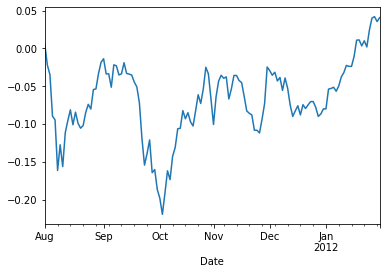

In [126]:
# Sanity check to make sure calculation is correct
returns['USA_EPU'].cumsum().plot()

In [127]:
# Reallocate capital and rebalance
position_size = capital / 30
position_size

3333.3251066676257

In [128]:
# Use new allocations to calculate next period
returns2 = semiannual[2][top15[2]] * position_size
returns2

,USA_CNY=X,USA_JPY=X,USA_RUB=X,USA_BRL=X,USA_ZAR=X,USA_EUR=X,USA_KXI,USA_ACWV,USA_MXN=X,USA_EPHE,...,CAN_HUG.TO,CAN_CVD.TO,CAN_SVR.TO,CAN_XGD.TO,CAN_HUZ.TO,CAN_HUC.TO,CAN_CBO.TO,CAN_CLF.TO,CAN_CHB.TO,CAN_XPF.TO
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,-5.481749,-16.160102,26.167514,15.918641,36.504116,17.611016,-5.069696,1.581649,22.038216,51.973464,...,17.191935,0.000000,-54.505061,1.450533,-38.069040,-8.695631,2.240138,-2.184355,8.635557,2.681677
2012-02-01,-2.639798,-3.928749,-33.146541,-2.863189,-15.499481,15.766615,33.003219,30.827526,-43.071629,84.370470,...,11.402480,5.212393,25.973962,-14.499022,66.235203,-23.248998,0.000000,2.185787,2.871081,10.718087
2012-02-02,-0.951080,-3.540046,8.541811,-25.026684,-55.528325,-23.538585,-3.770730,3.132824,-24.328195,56.657084,...,28.409021,0.000000,72.164770,53.880747,64.944712,-11.706146,0.000000,-2.184355,11.474441,10.683734
2012-02-03,-1.374175,-0.393757,3.695679,-26.178450,-10.615131,8.340995,28.941668,15.649414,-34.570597,17.243624,...,-60.093748,2.602127,-62.226553,-83.118167,-79.999803,0.000000,-4.477267,-4.371574,2.858769,7.987201
2012-02-06,0.211499,16.233442,1.635792,-5.432344,-42.247024,2.627424,-7.485011,-24.922057,1.317228,-7.917637,...,-19.124068,0.000000,3.427584,-11.757761,-9.107446,49.926455,2.241644,0.000000,5.712639,2.656036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,0.782949,-8.683305,30.576933,14.895531,24.485390,17.377907,0.000000,15.154922,-26.624779,9.814722,...,59.034221,10.093339,32.216415,90.743878,88.837170,-3.323355,-2.200215,4.334623,2.773149,5.196142
2012-07-26,0.521843,-0.170706,-26.774916,-20.858744,-44.034132,-21.710235,80.207398,41.487414,-48.310480,46.483066,...,20.716750,5.031434,17.017614,45.151047,3.762218,0.000000,-4.403336,-6.493490,24.937594,5.188055
2012-07-27,-2.347926,9.431966,-37.955839,-20.662122,-61.441770,-38.039646,49.527636,36.507137,-42.604205,41.018116,...,10.294395,10.047702,21.163969,5.810561,26.305835,0.000000,-11.022900,-10.843608,11.001073,7.769989


In [129]:
# Concatenate to get continuous stream
pd.concat([returns, returns2])

,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_BRL=X,USA_EUR=X,USA_CNY=X,USA_EPU,USA_TUR,USA_EPHE,USA_ECH,...,CAN_HUZ.TO,CAN_SVR.TO,CAN_CWW.TO,USA_KXI,USA_ACWV,USA_MXN=X,USA_EIS,CAN_XFR.TO,CAN_CLF.TO,CAN_XPF.TO
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-01,-0.006651,-0.007357,0.002785,-0.010430,-0.002150,-0.002219,0.005180,-0.006188,0.009129,0.020165,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-02,0.003199,0.008252,0.004507,0.007307,0.007182,-0.000482,-0.027197,-0.030212,-0.015625,-0.027369,...,0.020950,0.043150,-0.032659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-03,-0.001614,0.010074,0.003179,0.003531,0.006275,0.000560,-0.012655,0.021165,0.000835,-0.013722,...,0.021986,0.026506,0.012862,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-04,-0.002884,-0.010607,-0.000783,-0.000192,-0.012613,-0.000342,-0.054844,-0.081509,-0.035476,-0.054244,...,-0.074220,-0.070423,-0.023810,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-05,0.028245,0.032729,0.014975,0.008829,0.020382,0.000124,-0.005046,-0.038793,0.000000,-0.021043,...,-0.012393,-0.021465,-0.018699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-25,-8.683305,24.485390,30.576933,14.895531,17.377907,0.782949,NaN,46.010896,9.814722,NaN,...,88.837170,32.216415,NaN,0.000000,15.154922,-26.624779,63.722102,1.841616,4.334623,5.196142
2012-07-26,-0.170706,-44.034132,-26.774916,-20.858744,-21.710235,0.521843,NaN,133.722014,46.483066,NaN,...,3.762218,17.017614,NaN,80.207398,41.487414,-48.310480,25.873157,0.000000,-6.493490,5.188055
2012-07-27,9.431966,-61.441770,-37.955839,-20.662122,-38.039646,-2.347926,NaN,77.917838,41.018116,NaN,...,26.305835,21.163969,NaN,49.527636,36.507137,-42.604205,73.812398,0.000000,-10.843608,7.769989


In [130]:
# Generalize to all time periods

capital = 100000
dollar_full_portfolio = pd.DataFrame()
pct_full_portfolio = pd.DataFrame()
PnL = {}

for i in range(1,len(semiannual.keys())):
    position_size = capital / 30
    returns = semiannual[i][top15[i]]
    
    
    # Remove an outlier
    returns[returns.values > 100] = 0
    
    pct_full_portfolio = pd.concat([pct_full_portfolio, returns])
    dollar_full_portfolio = pd.concat([dollar_full_portfolio, returns*position_size])
    
    capital += sum(returns.iloc[-1,:])
    
    PnL[i] = returns.sum(axis=1)

/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [133]:
dollar_full_portfolio = dollar_full_portfolio

<AxesSubplot:xlabel='Date'>

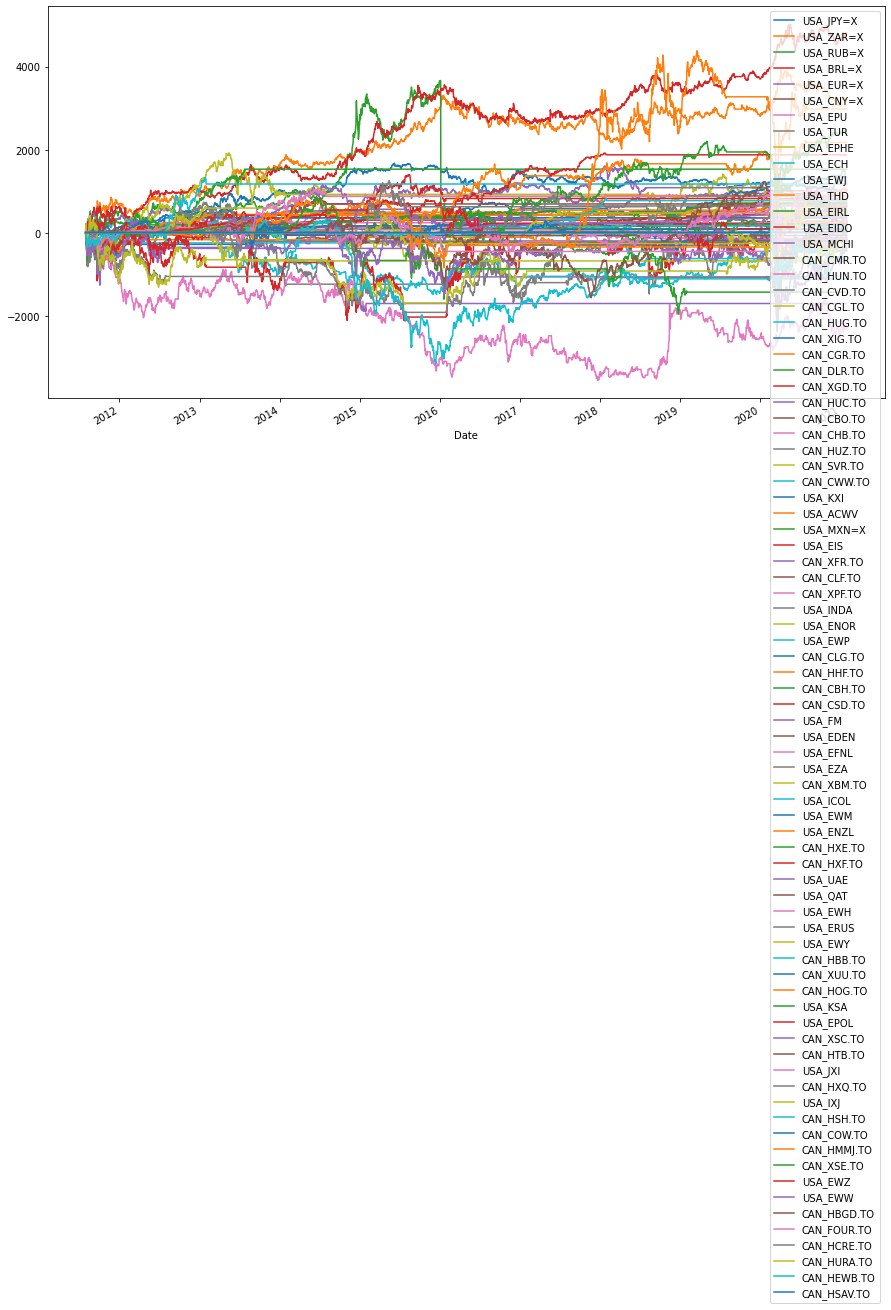

In [143]:
dollar_full_portfolio.cumsum().plot(figsize = (15,8))

<AxesSubplot:xlabel='None,Date'>

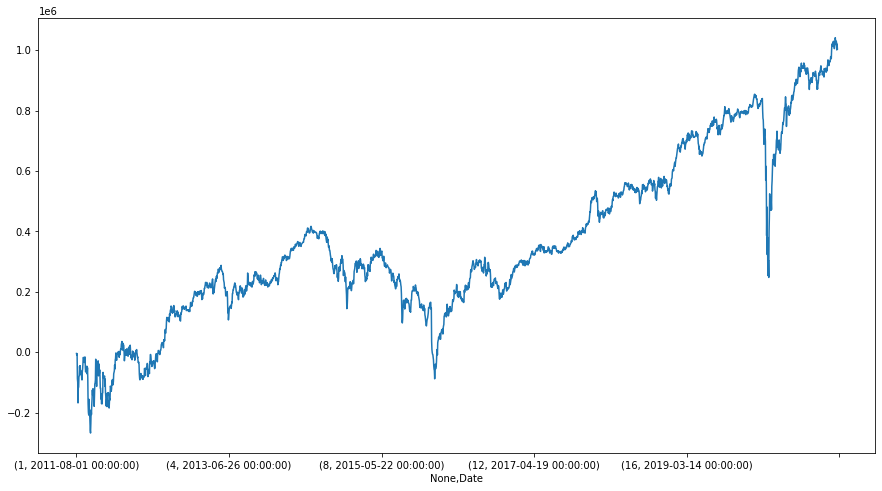

In [135]:
# PnL of whole portfolio 
(pd.concat(PnL)* 100000).cumsum().plot(figsize=(15,8))

In [136]:
PnL[1]

Date
2011-08-01   -0.042069
2011-08-02   -0.051131
2011-08-03    0.040789
2011-08-04   -0.825695
2011-08-05   -0.112453
                ...   
2012-01-25    0.299643
2012-01-26    0.048185
2012-01-27    0.182481
2012-01-30   -0.236100
2012-01-31    0.014321
Length: 132, dtype: float64

In [137]:
import importlib
import Risk_analytics
importlib.reload(Risk_analytics)
from Risk_analytics import risk
returns 


,USA_BRL=X,USA_EUR=X,USA_JPY=X,USA_ZAR=X,USA_RUB=X,USA_MXN=X,USA_CNY=X,USA_QAT,USA_UAE,USA_KSA,...,CAN_CLG.TO,CAN_CGL.TO,CAN_HUN.TO,CAN_CBH.TO,CAN_CLF.TO,CAN_CSD.TO,CAN_XFR.TO,CAN_XIG.TO,CAN_HBB.TO,CAN_SVR.TO
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-31,-0.002883,-0.007541,-0.003323,0.010690,0.011669,0.001042,0.001000,-0.004846,-0.009891,-0.004131,...,0.000531,0.009810,0.000000,0.000000,0.000000,0.001859,0.000500,0.000391,0.002695,0.042950
2020-08-03,0.013058,0.007598,0.011301,0.017776,0.014095,0.012057,-0.004724,0.000000,0.009990,-0.005656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-08-04,0.018674,0.001650,0.001549,0.009611,-0.017730,0.016401,0.000746,0.003043,0.000000,0.004551,...,0.000531,0.021251,0.022546,0.001571,0.000556,0.001855,-0.000999,0.005084,0.002880,0.062160
2020-08-05,-0.005358,-0.004352,-0.003923,0.009682,0.004822,0.000119,-0.000960,0.003641,-0.000989,0.011325,...,-0.001592,0.010107,0.005188,-0.001045,-0.001110,0.000000,0.000500,-0.000778,-0.002489,0.031456
2020-08-06,0.000132,-0.004844,-0.000578,-0.001625,-0.007828,-0.011349,-0.005464,0.006651,0.000990,0.007465,...,0.001595,0.012360,0.000000,0.001047,0.000556,0.003704,0.000999,0.004283,0.000960,0.076596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,0.021684,-0.000243,0.002618,0.012579,0.018489,0.010427,0.003002,-0.003778,0.003152,-0.003818,...,0.000000,-0.000652,0.011461,0.002073,0.000554,0.008907,0.000000,0.003945,0.001949,0.000767
2021-01-26,0.000000,0.001947,-0.000164,0.005359,-0.000434,0.008138,-0.000324,-0.003792,-0.012569,-0.005110,...,0.001598,-0.000652,0.005666,-0.001034,0.000000,-0.011183,0.000498,0.000786,-0.000778,0.006135
2021-01-27,-0.020437,-0.001336,-0.001513,-0.011305,-0.002817,-0.005814,-0.002315,0.002175,-0.000796,-0.005136,...,0.000000,-0.004569,0.014085,0.000518,-0.000554,0.004762,-0.000996,-0.001570,0.000584,-0.011433


In [138]:
pd.DataFrame(np.cov(returns))

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,0.000111,-0.000011,0.000089,0.000049,0.000097,-5.090674e-05,0.000021,-2.794534e-04,-2.558776e-05,1.524280e-04,...,-1.140370e-05,0.000011,4.038981e-05,0.000021,-0.000023,-0.000010,0.000013,-0.000036,0.000101,0.000038
1,-0.000011,0.000049,0.000001,0.000010,-0.000022,-7.539510e-07,0.000018,3.622103e-05,-5.926213e-07,-1.182083e-05,...,7.604350e-06,0.000033,-2.608930e-07,-0.000020,0.000015,0.000035,0.000004,-0.000019,0.000004,-0.000004
2,0.000089,0.000001,0.000213,0.000087,0.000163,-7.619288e-05,0.000056,-3.521154e-04,-4.886929e-07,2.129751e-04,...,2.736478e-05,0.000004,5.251080e-05,0.000017,-0.000025,0.000019,0.000012,-0.000009,0.000085,0.000038
3,0.000049,0.000010,0.000087,0.000124,0.000129,-4.240678e-05,0.000020,-2.194331e-04,1.677361e-05,1.410836e-04,...,-2.263730e-07,-0.000016,9.146880e-06,0.000005,-0.000022,0.000003,0.000010,0.000040,0.000017,0.000026
4,0.000097,-0.000022,0.000163,0.000129,0.000297,-6.103104e-05,0.000034,-4.138170e-04,1.079717e-05,2.555543e-04,...,-1.392429e-05,0.000028,4.412222e-05,0.000045,-0.000067,-0.000012,0.000006,0.000056,0.000090,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,-0.000010,0.000035,0.000019,0.000003,-0.000012,9.277242e-06,0.000020,4.355161e-05,-9.887392e-06,-1.226328e-05,...,2.729094e-05,0.000006,-8.583034e-06,-0.000009,0.000034,0.000059,-0.000004,0.000004,-0.000012,0.000006
127,0.000013,0.000004,0.000012,0.000010,0.000006,1.013388e-05,0.000018,-1.217199e-05,-1.937257e-05,1.625300e-05,...,1.625262e-05,-0.000052,-2.170277e-05,0.000004,0.000008,-0.000004,0.000028,0.000009,0.000011,0.000013
128,-0.000036,-0.000019,-0.000009,0.000040,0.000056,7.276907e-05,-0.000006,-5.890613e-07,-2.357210e-05,-3.484517e-07,...,3.359655e-05,-0.000111,-9.834210e-05,0.000022,0.000056,0.000004,0.000009,0.000201,-0.000084,0.000067
129,0.000101,0.000004,0.000085,0.000017,0.000090,-4.140388e-05,0.000053,-2.433607e-04,-2.005005e-05,1.494564e-04,...,-3.353233e-05,0.000090,5.935905e-05,0.000009,-0.000039,-0.000012,0.000011,-0.000084,0.000166,0.000026


In [139]:
import importlib
import Risk_analytics
importlib.reload(Risk_analytics)
from Risk_analytics import risk
risk_profile = risk(returns,np.ones(30),30)
risk_profile

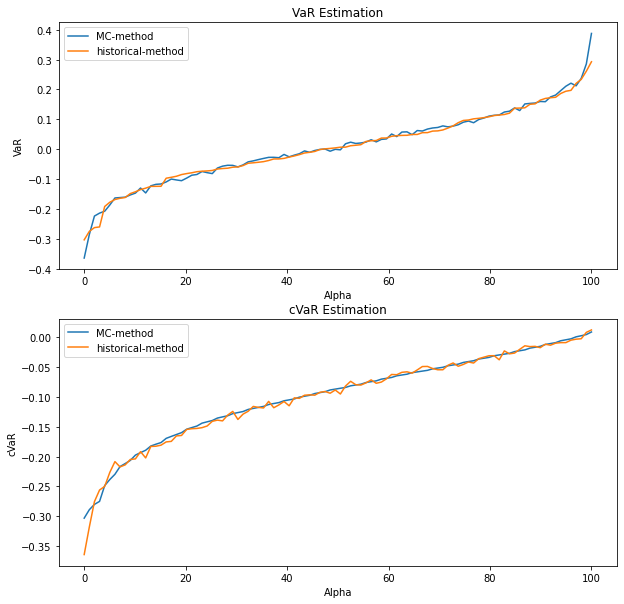

In [140]:
risk_profile.plot_VaR(1000)

In [141]:
risk_profile.max_drawdown()

-0.7128644741641676

In [142]:
risk_profile.sharpe_ratio(0.02)

0.7223784228526047